#### Business Problem:
PickMe wants to automate the process of categorizing food items into their respective food types based on their names. They have a dataset containing food item names and their corresponding food types. Manually categorizing food items is time-consuming, and they want a solution that can accurately predict the food type of a given food item name.

#### Objectives:

Develop an automated food type prediction model that can predict the food type (e.g., Desserts, Cakes, Rice, Noodles, etc.) based on the name of the food item.

### Loading required python modules

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM
from tensorflow.keras.layers import Dropout

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier

### Loading the data set

In [2]:
data = pd.read_csv("/content/dataset_usecase2 (1).csv")

### EDA

In [3]:
# Display the dataset
data.head(20)

,Unnamed: 0,itemname,tag
0,0,Biscuit Pudding,Desserts
1,14,Jelly Yoghurt 425ml,Desserts
2,16,(3) Jelly Yoghurt 80ml,Desserts
3,17,Watalappam 425ml,Desserts
4,19,Two Chocolate Balls,Desserts
5,26,Two Chocolate Cupcakes Medium,Cakes
6,28,Chocolate Cupcake Large,Cakes
7,32,Two Chocolate Triangles,Cakes
8,34,Fish Rice & Curry (2),Rice
9,36,Two Chocolate Eclairs,Desserts


In [4]:
# Display basic information about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15782 entries, 0 to 15781
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15782 non-null  int64 
 1   itemname    15782 non-null  object
 2   tag         15782 non-null  object
dtypes: int64(1), object(2)
memory usage: 370.0+ KB
None


In [5]:
# Check for missing values
print(data.isnull().sum())

Unnamed: 0    0
itemname      0
tag           0
dtype: int64


No missing values found

In [6]:
# Explore unique food types
unique_food_types = data['tag'].unique()
print("Unique Food Types:", unique_food_types)
print(f"There are about {len(unique_food_types)} unqiue food types are present in the dataset.")

Unique Food Types: ['Desserts' 'Cakes' 'Rice' 'Noodles' 'Roti' 'Bread' 'Short eats'
 'Biriyani' 'Kottu' 'Pasta' 'Bites' 'Curry' 'Condiments' 'Tea' 'Coffee'
 'Soft Drinks' 'Fruit Juice' 'Shakes' 'Sushi' 'Stir Fry' 'Salad' 'Soup'
 'Fast Food' 'Seafood' 'Pizza' 'Dosa' 'Street Food' 'Burger' 'Submarine'
 'Wrap' 'BBQ' 'Waffles' 'Indian Sweets' 'Shawarma' 'Shellfish' 'Ice Cream'
 'Sandwiches' 'Bubble Tea']
There are about 38 unqiue food types are present in the dataset.


Food Type Counts:
 Rice             2238
Stir Fry         1293
Kottu            1174
Curry             907
Desserts          833
Bites             702
Short eats        699
Noodles           691
Roti              638
Pasta             521
Shakes            495
Cakes             489
Burger            481
Fruit Juice       430
Soup              370
Pizza             326
Sandwiches        284
Bread             279
Biriyani          268
Salad             265
Submarine         260
Coffee            213
Dosa              204
Soft Drinks       197
Indian Sweets     189
Wrap              170
Seafood           153
Ice Cream         153
Fast Food         143
Tea               138
Condiments        135
Sushi             115
Waffles           100
Shawarma           69
Street Food        64
BBQ                52
Bubble Tea         25
Shellfish          19
Name: tag, dtype: int64


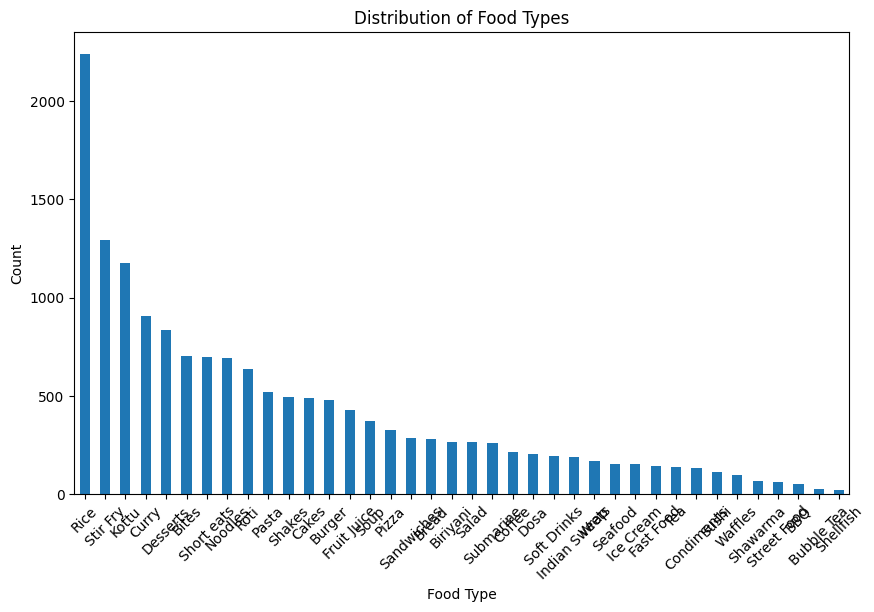

In [7]:
# Count the occurrences of each food type
food_type_counts = data['tag'].value_counts()
print("Food Type Counts:\n", food_type_counts)

# Plot a bar chart of food type counts
plt.figure(figsize=(10, 6))
food_type_counts.plot(kind='bar')
plt.xlabel("Food Type")
plt.ylabel("Count")
plt.title("Distribution of Food Types")
plt.xticks(rotation=45)
plt.show()

Descriptive Statistics of Text Lengths:
 count    15782.000000
mean        22.193131
std          9.264168
min          3.000000
25%         16.000000
50%         21.000000
75%         27.000000
max        102.000000
Name: itemname_length, dtype: float64


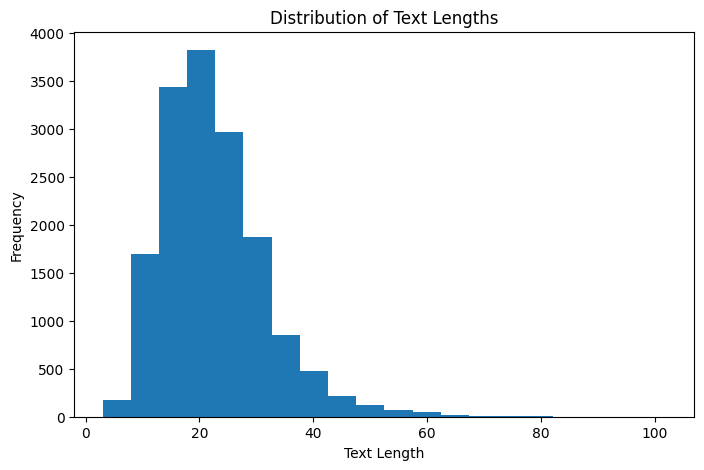

In [8]:
# Explore text lengths of food item names
data['itemname_length'] = data['itemname'].apply(len)
print("Descriptive Statistics of Text Lengths:\n", data['itemname_length'].describe())

# Plot a histogram of text lengths
plt.figure(figsize=(8, 5))
plt.hist(data['itemname_length'], bins=20)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.show()

Average length of the input itemname is 22.2 with a Std. dev of 9.2

### Data pre-processing

In [9]:
def clean_text(text):
    # Remove special characters and numbers
    cleaned_text = re.sub('[^a-zA-Z\s]', '', text)
    return cleaned_text.lower()  # Convert to lowercase

# Apply the cleaning function to the 'itemname' column
data['cleaned_itemname'] = data['itemname'].apply(clean_text)

In [10]:
data.head(20)

,Unnamed: 0,itemname,tag,itemname_length,cleaned_itemname
0,0,Biscuit Pudding,Desserts,15,biscuit pudding
1,14,Jelly Yoghurt 425ml,Desserts,19,jelly yoghurt ml
2,16,(3) Jelly Yoghurt 80ml,Desserts,22,jelly yoghurt ml
3,17,Watalappam 425ml,Desserts,16,watalappam ml
4,19,Two Chocolate Balls,Desserts,19,two chocolate balls
5,26,Two Chocolate Cupcakes Medium,Cakes,29,two chocolate cupcakes medium
6,28,Chocolate Cupcake Large,Cakes,23,chocolate cupcake large
7,32,Two Chocolate Triangles,Cakes,23,two chocolate triangles
8,34,Fish Rice & Curry (2),Rice,22,fish rice curry
9,36,Two Chocolate Eclairs,Desserts,21,two chocolate eclairs


## Approach 1: deep learning based approach

In [11]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_itemname'])
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences and pad them
sequences = tokenizer.texts_to_sequences(data['cleaned_itemname'])
max_seq_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

In [12]:
padded_sequences

array([[ 157,  111,    0, ...,    0,    0,    0],
       [ 274,  563,   35, ...,    0,    0,    0],
       [ 274,  563,   35, ...,    0,    0,    0],
       ...,
       [   1,  122,    0, ...,    0,    0,    0],
       [  63, 3249,    0, ...,    0,    0,    0],
       [  30,    1,    0, ...,    0,    0,    0]], dtype=int32)

In [13]:
# occurences of each unique word
tokenizer.word_docs

defaultdict(int,
            {'pudding': 92,
             'biscuit': 65,
             'jelly': 30,
             'yoghurt': 10,
             'ml': 254,
             'watalappam': 9,
             'balls': 12,
             'two': 15,
             'chocolate': 544,
             'cupcakes': 8,
             'medium': 69,
             'large': 255,
             'cupcake': 13,
             'triangles': 1,
             'fish': 879,
             'rice': 1758,
             'curry': 823,
             'eclairs': 10,
             'noodles': 612,
             'egg': 734,
             'chicken': 3108,
             'mix': 201,
             'gravy': 70,
             'parata': 94,
             'pieces': 125,
             'red': 206,
             'vegetable': 640,
             'pcs': 90,
             'bread': 161,
             'bun': 148,
             'tea': 117,
             'kimbulla': 1,
             'seeni': 40,
             'sambol': 115,
             'vanilla': 101,
             'beef': 990,
       

In [14]:
# Encode food types using LabelEncoder
label_encoder = LabelEncoder()
data['encoded_tag'] = label_encoder.fit_transform(data['tag'])
num_classes = len(np.unique(data['encoded_tag']))

In [15]:
data.head(20)

,Unnamed: 0,itemname,tag,itemname_length,cleaned_itemname,encoded_tag
0,0,Biscuit Pudding,Desserts,15,biscuit pudding,10
1,14,Jelly Yoghurt 425ml,Desserts,19,jelly yoghurt ml,10
2,16,(3) Jelly Yoghurt 80ml,Desserts,22,jelly yoghurt ml,10
3,17,Watalappam 425ml,Desserts,16,watalappam ml,10
4,19,Two Chocolate Balls,Desserts,19,two chocolate balls,10
5,26,Two Chocolate Cupcakes Medium,Cakes,29,two chocolate cupcakes medium,6
6,28,Chocolate Cupcake Large,Cakes,23,chocolate cupcake large,6
7,32,Two Chocolate Triangles,Cakes,23,two chocolate triangles,6
8,34,Fish Rice & Curry (2),Rice,22,fish rice curry,20
9,36,Two Chocolate Eclairs,Desserts,21,two chocolate eclairs,10


### Splitting the dataset into training and testing sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['encoded_tag'], test_size=0.2, random_state=42)

### Model building and training

In [19]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_seq_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Train the model on the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

Epoch 1/50
178/178 [==============================] - 22s 92ms/step - loss: 2.9855 - accuracy: 0.1833 - val_loss: 2.2996 - val_accuracy: 0.3365
Epoch 2/50
178/178 [==============================] - 16s 91ms/step - loss: 2.0757 - accuracy: 0.3971 - val_loss: 1.7139 - val_accuracy: 0.4885
Epoch 3/50
178/178 [==============================] - 16s 88ms/step - loss: 1.5486 - accuracy: 0.5566 - val_loss: 1.3275 - val_accuracy: 0.6342
Epoch 4/50
178/178 [==============================] - 18s 103ms/step - loss: 1.2191 - accuracy: 0.6714 - val_loss: 1.2151 - val_accuracy: 0.6825
Epoch 5/50
178/178 [==============================] - 16s 89ms/step - loss: 1.0421 - accuracy: 0.7319 - val_loss: 1.0874 - val_accuracy: 0.7213
Epoch 6/50
178/178 [==============================] - 16s 89ms/step - loss: 0.9231 - accuracy: 0.7670 - val_loss: 1.0119 - val_accuracy: 0.7451
Epoch 7/50
178/178 [==============================] - 16s 88ms/step - loss: 0.8509 - accuracy: 0.7923 - val_loss: 0.9555 - val_accuracy

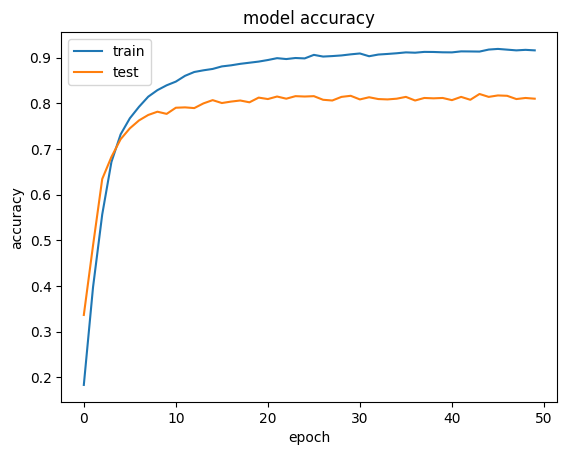

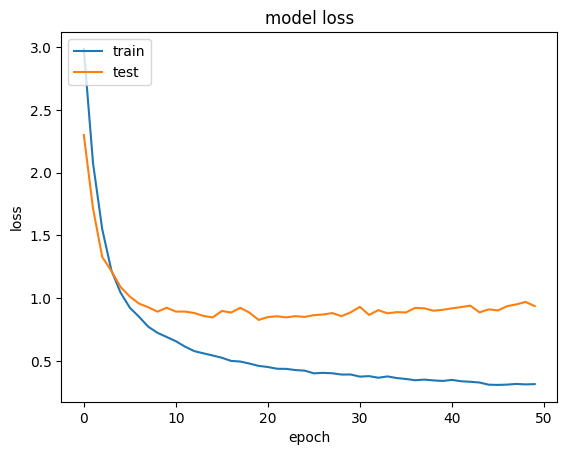

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model Evaluation

In [22]:
# Evaluating the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Train Loss: {loss:.4f}")
print(f"Train Accuracy: {accuracy:.4f}")

99/99 [==============================] - 2s 17ms/step - loss: 0.9675 - accuracy: 0.7989
Test Loss: 0.9675
Test Accuracy: 0.7989
395/395 [==============================] - 7s 17ms/step - loss: 0.2963 - accuracy: 0.9190
Train Loss: 0.2963
Train Accuracy: 0.9190


In [ ]:
# iteration 1 with only one dense layer (64) and no drop out
# Test Loss: 1.8034
# Test Accuracy: 0.7555

# iteration 2 with two dense layers (64, 32) and drop out
# Test Loss: 2.1679
# Test Accuracy: 0.7732

# iteration 3 with one dense layers (64) and drop out
# Test Loss: 2.3678
# Test Accuracy: 0.7922

# iteration 4 using LSTM model with batch size 64
# Test Loss: 0.9675
# Test Accuracy: 0.7989
# Train Loss: 0.2963
# Train Accuracy: 0.9190


## Approach 2: machine learning based approach

### Splitting the dataset into training and testing sets

In [44]:
# Splitting the data
X = data['cleaned_itemname']
y = data['encoded_tag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Vectorization

In [45]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [46]:
print(X_train_tfidf)

  (0, 2275)	0.6874168565752623
  (0, 1691)	0.7262630827022569
  (1, 643)	0.5203852422758779
  (1, 2205)	0.418697760939409
  (1, 467)	0.34392747474290547
  (1, 2220)	0.6600039975051436
  (2, 291)	1.0
  (3, 1826)	0.5255845807010374
  (3, 909)	0.43803212257779006
  (3, 2097)	0.5588363642646319
  (3, 175)	0.4686049787345396
  (4, 943)	0.7479894961880175
  (4, 1597)	0.6637105646231616
  (5, 909)	0.5336964959304167
  (5, 175)	0.57094633529247
  (5, 2205)	0.4820665678897331
  (5, 467)	0.3959799951647894
  (6, 600)	0.5142482113571417
  (6, 1164)	0.5501648997221916
  (6, 2230)	0.5601230993609048
  (6, 909)	0.34515137808211793
  (7, 1381)	0.7269802992165371
  (7, 745)	0.5667169088313958
  (7, 175)	0.38772617888868666
  (8, 2410)	0.8338637981072279
  :	:
  (12616, 2543)	0.45860239196222957
  (12616, 2496)	0.42462322386870693
  (12616, 1385)	0.3848491209153142
  (12616, 1693)	0.4350193205832847
  (12617, 1457)	0.8545181666432361
  (12617, 362)	0.5194215079072898
  (12618, 1316)	0.6766385066083852


### Hyperparameter tuning

In [49]:
# Random Forest Classifier with Hyperparameter Tuning
rf_classifier = RandomForestClassifier(random_state=42)
param_dist = {'n_estimators': [50, 100, 200],
              'max_features': ['sqrt', 'log2'],
              'max_depth': [6, 9, 15, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]
              }

random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_dist, n_iter=20, cv=3)
random_search.fit(X_train_tfidf, y_train)

best_rf_classifier = random_search.best_estimator_
print(random_search.best_params_)

# Predictions using the best model
y_pred_rf_best = best_rf_classifier.predict(X_test_tfidf)
y_train_pred_rf_best = best_rf_classifier.predict(X_train_tfidf)

# Evaluation
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
print(f"Best Random Forest Test Accuracy: {accuracy_rf_best:.4f}")

accuracy_rf_best = accuracy_score(y_train, y_train_pred_rf_best)
print(f"Best Random Forest Train Accuracy: {accuracy_rf_best:.4f}")

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best Random Forest Test Accuracy: 0.6411
Best Random Forest Train Accuracy: 0.6709


In [ ]:
# XGBoost Classifier with Hyperparameter Tuning
xgb_classifier = XGBClassifier(random_state=42)
param_dist = {'n_estimators': [50, 100, 150],
              'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [3, 5],
              'subsample': [0.9, 1.0],
              'colsample_bytree': [0.9, 1.0]
              }

random_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_dist, n_iter=10, cv=3)
random_search.fit(X_train_tfidf, y_train)

best_xgb_classifier = random_search.best_estimator_

In [53]:
print(random_search.best_params_)

{'subsample': 0.9, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1.0}


In [52]:
# Predictions using the best model
y_pred_xgb_best = best_xgb_classifier.predict(X_test_tfidf)
y_train_pred_xgb_best = best_xgb_classifier.predict(X_train_tfidf)

# Evaluation
accuracy_xgb_best = accuracy_score(y_test, y_pred_xgb_best)
print(f"Best XGBoost Test Accuracy: {accuracy_xgb_best:.4f}")

accuracy_xgb_best = accuracy_score(y_train, y_train_pred_xgb_best)
print(f"Best XGBoost Train Accuracy: {accuracy_xgb_best:.4f}")

Best XGBoost Test Accuracy: 0.7827
Best XGBoost Train Accuracy: 0.8755


### Conclusion

For the food type prediction task, it was observed that the LSTM model outperformed the other methods in terms of both training and test accuracy. The LSTM model's ability to understand the context and relationships within the food item names allowed it to achieve higher accuracy compared to traditional machine learning methods.

However, it's important to note that the LSTM model may require more computational resources and time for training compared to other models that had been tried. Therefore, while it offers better accuracy, it's essential to consider the trade-offs between accuracy, computational resources,
and training time when choosing the final model.





